In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
  x = keras.layers.Conv2D(filters=channel, 
                          kernel_size=kernel_size, 
                          kernel_regularizer=keras.regularizers.l2(1e-4), 
                          padding='same', 
                          strides=strides)(input_layer)
  x = keras.layers.BatchNormalization()(x)

  if activation:
    x = keras.layers.Activation(activation)(x)
  
  return x

In [4]:
def build_resnet_block(input_layer, 
                       num_conv=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
  x = input_layer

  # ResNet-50
  if is_50:
    for i in range(num_conv):
      if i == 0:
        shortcut = conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
        x = conv_block(x, channel, (1, 1), strides=2)
        x = conv_block(x, channel, (3, 3), strides=1)
        x = conv_block(x, channel * 4, (1, 1), strides=1, activation=None)
      else:
        shortcut = x
        x = conv_block(x, channel, (1, 1), strides=1)
        x = conv_block(x, channel, (3, 3), strides=1)
        x = conv_block(x, channel * 4, (1, 1), strides=1, activation=None)
      
      x = keras.layers.Add()([x, shortcut])
      x = keras.layers.Activation('relu')(x)

  # ResNet-34
  else:
    for i in range(num_conv):
      if block_num > 0 and i == 0:
        # Convolution block
        shortcut = conv_block(x, channel, (1, 1), strides=2, activation=None)
        x = conv_block(x, channel, (3, 3), strides=2) # strides=(2, 2)
        x = conv_block(x, channel, (3, 3), strides=1, activation=None) # strides=(1, 1)
      else:
        # Identity block
        shortcut = x
        x = conv_block(x, channel, (3, 3), strides=1) # strides=(1, 1)
        x = conv_block(x, channel, (3, 3), strides=1, activation=None) # strides(1, 1)
      
      x = keras.layers.Add()([x, shortcut])
      x = keras.layers.Activation('relu')(x)
  
  return x

In [5]:
def build_resnet(input_shape=(32, 32, 3),
                 num_conv_list=[3, 4, 6, 3],
                 channel_list=[64, 128, 256, 512],
                 num_classes=10,
                 is_50=True,
                 activation='softmax',
                 name='ResNet_50'):
  assert len(num_conv_list) == len(channel_list)

  input_layer = keras.layers.Input(shape=input_shape)

  x = conv_block(input_layer, 64, (7, 7), strides=2)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

  for block_num, (num_conv, channel) in enumerate(zip(num_conv_list, channel_list)):
    x = build_resnet_block(x,
                           num_conv=num_conv,
                           channel=channel,
                           block_num=block_num,
                           is_50=is_50)
  
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(num_classes,
                         activation=activation,
                         kernel_initializer='he_normal')(x)
  
  model = keras.Model(inputs=input_layer, outputs=x, name=name)
  return model

In [6]:
resnet_50 = build_resnet(input_shape=(32, 32, 3),
                         is_50=True,
                         name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [7]:
resnet_34 = build_resnet(input_shape=(32, 32, 3),
                         is_50=False,
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 16, 16, 64)   256         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 16, 16, 64)   0           batch_normalization_53[0][0]     
__________________________________________________________________________________________

#### Plain Resnet

In [8]:
def build_plain_block(input_layer,
                      num_conv=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
  
  x = input_layer
  
  if is_50:
    for i in range(num_conv):
      if block_num > 0 and i == 0:
        x = conv_block(x, channel, (1, 1), strides=2)
        x = conv_block(x, channel, (3, 3), strides=2)
        x = conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
      else:
        x = conv_block(x, channel, (1, 1), strides=2)
        x = conv_block(x, channel, (3, 3), strides=2)
        x = conv_block(x, channel * 4, (1, 1), strides=2, activation=None)
  else:
    for i in range(num_conv):
      if block_num > 0 and i == 0:
        x = conv_block(x, channel, (3, 3), strides=2)
        x = conv_block(x, channel, (3, 3), strides=2)
      else:
        x = conv_block(x, channel, (3, 3), strides=2)
        x = conv_block(x, channel, (3, 3), strides=2)

  return x

In [9]:
def build_plainnet(input_shape=(32, 32, 3),
                   num_conv_list=[3, 4, 6, 3],
                   channel_list=[64, 128, 256, 512],
                   num_classes=10,
                   is_50=True,
                   activation='softmax',
                   name='Plain_50'):
  assert len(num_conv_list) == len(channel_list)

  input_layer = keras.layers.Input(shape=input_shape)

  x = conv_block(input_layer, 64, (7, 7), strides=2)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

  for block_num, (num_conv, channel) in enumerate(zip(num_conv_list, channel_list)):
    x = build_plain_block(x,
                          num_conv=num_conv,
                          channel=channel,
                          block_num=block_num,
                          is_50=is_50)
  
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(num_classes,
                         activation=activation,
                         kernel_initializer='he_normal')(x)
  return keras.Model(inputs=input_layer, outputs=x, name=name)

In [10]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 28, 28, 64)        256

In [11]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 28, 28, 64)        256

In [12]:
(train_ds, test_ds), ds_info = tfds.load('cats_vs_dogs',
                                         split=['train[:80%]', 'train[80%:]'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMMS5US/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [13]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [14]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [15]:
ds_info.features['label'].num_classes

2

In [16]:
ds_info.features['label'].names

['cat', 'dog']

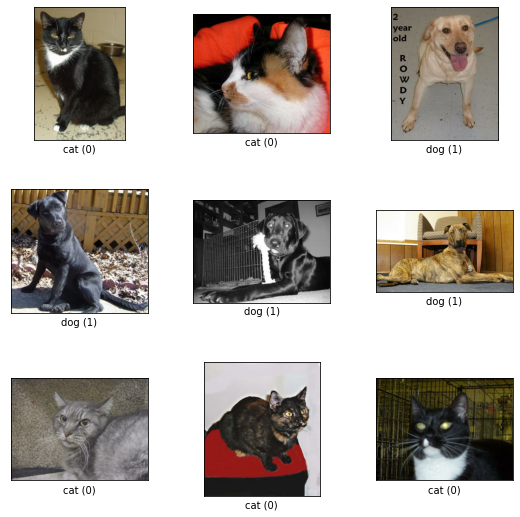

In [17]:
fig = tfds.show_examples(train_ds, ds_info)

In [18]:
def normalize_and_resize_img(image, labels):
  image = tf.cast(image, tf.float32) / 255.
  image = tf.image.resize(image, [224, 224])
  return image, labels

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
  ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
  ds = ds.batch(batch_size)
  if not is_test:
    ds = ds.repeat()
    ds = ds.shuffle(200)
  return ds

In [20]:
BATCH_SIZE = 16
EPOCH = 10

In [21]:
train_ds = apply_normalize_on_dataset(train_ds, batch_size=BATCH_SIZE)
test_ds = apply_normalize_on_dataset(test_ds, batch_size=BATCH_SIZE)

#### ResNet34

In [22]:
resnet_34 = build_resnet(input_shape=(224, 224, 3),
                         num_classes=1,
                         is_50=False,
                         activation='sigmoid',
                         name='ResNet_34')

In [23]:
resnet_34.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

probe_resnet_34 = resnet_34.fit(train_ds,
                                steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                                validation_steps=int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                                epochs=EPOCH,
                                validation_data=test_ds,
                                verbose=1,
                                use_multiprocessing=True)

Epoch 1/10
1163/1163 [==============================] - 109s 72ms/step - loss: 1.2133 - accuracy: 0.5728 - val_loss: 2.7477 - val_accuracy: 0.5047
Epoch 2/10
1163/1163 [==============================] - 82s 71ms/step - loss: 0.8281 - accuracy: 0.5997 - val_loss: 1.3262 - val_accuracy: 0.5489
Epoch 3/10
1163/1163 [==============================] - 82s 71ms/step - loss: 0.7416 - accuracy: 0.6060 - val_loss: 0.8691 - val_accuracy: 0.5615
Epoch 4/10
1163/1163 [==============================] - 82s 71ms/step - loss: 0.7062 - accuracy: 0.6366 - val_loss: 0.7101 - val_accuracy: 0.6598
Epoch 5/10
1163/1163 [==============================] - 82s 70ms/step - loss: 0.6786 - accuracy: 0.6701 - val_loss: 0.7758 - val_accuracy: 0.6450
Epoch 6/10
1163/1163 [==============================] - 82s 70ms/step - loss: 0.6434 - accuracy: 0.7045 - val_loss: 0.9111 - val_accuracy: 0.5464
Epoch 7/10
1163/1163 [==============================] - 82s 71ms/step - loss: 0.6124 - accuracy: 0.7433 - val_loss: 0.7792 

In [24]:
df_resnet_34 = pd.DataFrame({
    'train_loss': probe_resnet_34.history['loss'],
    'val_acc': probe_resnet_34.history['val_accuracy']
})
df_resnet_34.to_csv('probe_resnet_34.csv', index=False)

#### ResNet 50

In [25]:
resnet_50 = build_resnet(input_shape=(224, 224, 3),
                         num_classes=1,
                         is_50=True,
                         activation='sigmoid',
                         name='ResNet_50')

In [26]:
resnet_50.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

probe_resnet_50 = resnet_50.fit(train_ds,
                                steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                                validation_steps=int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                                epochs=EPOCH,
                                validation_data=test_ds,
                                verbose=1,
                                use_multiprocessing=True)

Epoch 1/10
1163/1163 [==============================] - 84s 64ms/step - loss: 2.2463 - accuracy: 0.6203 - val_loss: 1.7072 - val_accuracy: 0.6946
Epoch 2/10
1163/1163 [==============================] - 73s 62ms/step - loss: 1.3912 - accuracy: 0.7041 - val_loss: 1.1853 - val_accuracy: 0.6946
Epoch 3/10
1163/1163 [==============================] - 72s 62ms/step - loss: 1.0106 - accuracy: 0.7336 - val_loss: 1.0628 - val_accuracy: 0.6431
Epoch 4/10
1163/1163 [==============================] - 73s 63ms/step - loss: 0.8255 - accuracy: 0.7691 - val_loss: 1.2345 - val_accuracy: 0.5981
Epoch 5/10
1163/1163 [==============================] - 73s 63ms/step - loss: 0.7072 - accuracy: 0.7939 - val_loss: 1.6565 - val_accuracy: 0.6393
Epoch 6/10
1163/1163 [==============================] - 73s 63ms/step - loss: 0.6395 - accuracy: 0.8139 - val_loss: 140.9134 - val_accuracy: 0.4832
Epoch 7/10
1163/1163 [==============================] - 73s 63ms/step - loss: 0.5937 - accuracy: 0.8395 - val_loss: 1.0316

In [27]:
df_resnet_50 = pd.DataFrame({
    'train_loss': probe_resnet_50.history['loss'],
    'val_acc': probe_resnet_50.history['val_accuracy']
})
df_resnet_50.to_csv('probe_resnet_50.csv', index=False)

#### PlainNet 34

In [28]:
plain_34 = build_plainnet(input_shape=(224, 224, 3),
                          num_classes=1,
                          is_50=False,
                          activation='sigmoid',
                          name='Plain_34')

In [29]:
plain_34.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

probe_plain_34 = plain_34.fit(train_ds,
                              steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                              validation_steps=int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                              epochs=EPOCH,
                              validation_data=test_ds,
                              verbose=1,
                              use_multiprocessing=True)

Epoch 1/10
1163/1163 [==============================] - 57s 42ms/step - loss: 0.8469 - accuracy: 0.5230 - val_loss: 0.8063 - val_accuracy: 0.5520
Epoch 2/10
1163/1163 [==============================] - 49s 42ms/step - loss: 0.8139 - accuracy: 0.5338 - val_loss: 0.8068 - val_accuracy: 0.4972
Epoch 3/10
1163/1163 [==============================] - 48s 42ms/step - loss: 0.8070 - accuracy: 0.5174 - val_loss: 0.8009 - val_accuracy: 0.4825
Epoch 4/10
1163/1163 [==============================] - 48s 41ms/step - loss: 0.7925 - accuracy: 0.5373 - val_loss: 0.7746 - val_accuracy: 0.5517
Epoch 5/10
1163/1163 [==============================] - 48s 42ms/step - loss: 0.7851 - accuracy: 0.5296 - val_loss: 0.7849 - val_accuracy: 0.5175
Epoch 6/10
1163/1163 [==============================] - 48s 42ms/step - loss: 0.7963 - accuracy: 0.5030 - val_loss: 0.7895 - val_accuracy: 0.5181
Epoch 7/10
1163/1163 [==============================] - 49s 42ms/step - loss: 0.7987 - accuracy: 0.5026 - val_loss: 0.9122 -

In [30]:
df_plain_34 = pd.DataFrame({
    'train_loss': probe_plain_34.history['loss'],
    'val_acc': probe_plain_34.history['val_accuracy']
})
df_plain_34.to_csv('probe_plain_34.csv', index=False)

#### PlainNet 50

In [31]:
plain_50 = build_plainnet(input_shape=(224, 224, 3),
                          num_classes=1,
                          is_50=True,
                          activation='sigmoid',
                          name='Plain_50')

In [32]:
plain_50.compile(loss='binary_crossentropy',
                 optimizer=keras.optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

probe_plain_50 = plain_50.fit(train_ds,
                              steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                              validation_steps=int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                              epochs=EPOCH,
                              validation_data=test_ds,
                              verbose=1,
                              use_multiprocessing=True)

Epoch 1/10
1163/1163 [==============================] - 62s 45ms/step - loss: 2.1109 - accuracy: 0.5030 - val_loss: 33.4497 - val_accuracy: 0.5272
Epoch 2/10
1163/1163 [==============================] - 52s 45ms/step - loss: 2.0593 - accuracy: 0.5092 - val_loss: 1.9455 - val_accuracy: 0.4886
Epoch 3/10
1163/1163 [==============================] - 52s 45ms/step - loss: 1.9146 - accuracy: 0.4940 - val_loss: 1.8029 - val_accuracy: 0.4871
Epoch 4/10
1163/1163 [==============================] - 53s 45ms/step - loss: 1.7671 - accuracy: 0.5021 - val_loss: 1.6871 - val_accuracy: 0.5032
Epoch 5/10
1163/1163 [==============================] - 52s 45ms/step - loss: 1.6465 - accuracy: 0.5019 - val_loss: 1.8602 - val_accuracy: 0.4877
Epoch 6/10
1163/1163 [==============================] - 53s 45ms/step - loss: 1.5707 - accuracy: 0.4980 - val_loss: 1.5354 - val_accuracy: 0.4892
Epoch 7/10
1163/1163 [==============================] - 52s 45ms/step - loss: 1.4975 - accuracy: 0.4979 - val_loss: 1.4743 

In [33]:
df_plain_50 = pd.DataFrame({
    'train_loss': probe_plain_50.history['loss'],
    'val_acc': probe_plain_50.history['val_accuracy']
})
df_plain_50.to_csv('probe_plain_50.csv', index=False)

#### Result Comparison

In [34]:
probe_resnet_34 = pd.read_csv('probe_resnet_34.csv')
probe_resnet_50 = pd.read_csv('probe_resnet_50.csv')
probe_plain_34 = pd.read_csv('probe_plain_34.csv')
probe_plain_50 = pd.read_csv('probe_plain_50.csv')

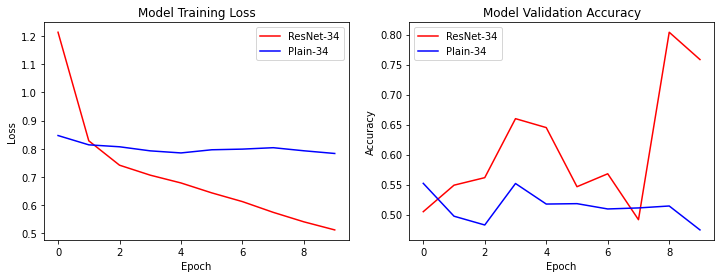

In [35]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(probe_resnet_34['train_loss'], 'r')
plt.plot(probe_plain_34['train_loss'], 'b')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(probe_resnet_34['val_acc'], 'r')
plt.plot(probe_plain_34['val_acc'], 'b')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

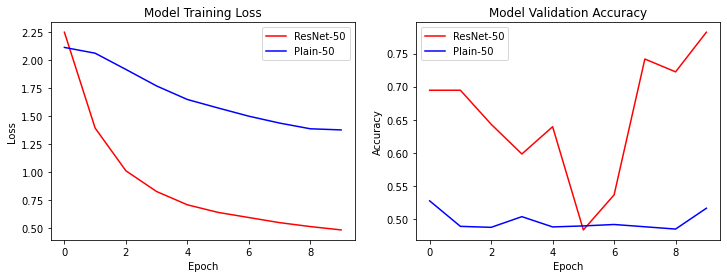

In [36]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(probe_resnet_50['train_loss'], 'r')
plt.plot(probe_plain_50['train_loss'], 'b')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(probe_resnet_50['val_acc'], 'r')
plt.plot(probe_plain_50['val_acc'], 'b')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

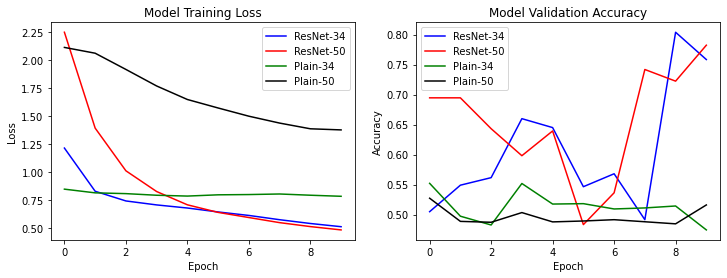

In [37]:
# Full comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(probe_resnet_34['train_loss'], 'b')
plt.plot(probe_resnet_50['train_loss'], 'r')
plt.plot(probe_plain_34['train_loss'], 'g')
plt.plot(probe_plain_50['train_loss'], 'k')
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(probe_resnet_34['val_acc'], 'b')
plt.plot(probe_resnet_50['val_acc'], 'r')
plt.plot(probe_plain_34['val_acc'], 'g')
plt.plot(probe_plain_50['val_acc'], 'k')
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

In [38]:
# Validation accuracy comparison
accuracy = {
    'Plain': [round(probe_plain_34['val_acc'].mean(), 4),
              round(probe_plain_50['val_acc'].mean(), 4)],
    'ResNet': [round(probe_resnet_34['val_acc'].mean(), 4), 
               round(probe_resnet_50['val_acc'].mean(), 4)]
}

df_acc = pd.DataFrame(accuracy, index=['34 layers', '50 layers'])
df_acc

,Plain,ResNet
34 layers,0.5128,0.6088
50 layers,0.4963,0.6536
